# **Birds of a feather**

Observing latent space interpolations between bird song syllables between common, threatened, and now-extinct species of birds.

---
## Data

I am using the [Nanni et al. 2016 bird songs dataset](http://www.din.uem.br/yandre/birds/bird_songs_46.tar.gz) referenced in [this paper by Mangalam Sankupellay and Dmitry Konovalov](https://www.acoustics.asn.au/conference_proceedings/AAS2018/papers/p134.pdf).

This is a ~10GB collection of 2814 bird song syllables from 46 different species of birds in southern Brazil.  Note that it appears all syllables have been looped until the audio is at least 1min 20s long...

---
## Methodology

I will be using `librosa` to encode these audio files as Mel spectrograms.  Then, I will train an autoencoder on the spectrograms.  I will create interpolated frames between multiple bird samples in the latent space, and then I will decode these interpolated frames.  Finally, I will convert all chosen decoded frames back to audio files.

---
## Data generation and tools

In [1]:
from IPython.display import Audio
import numpy as np
import librosa
from librosa import display
import librosa.feature
import matplotlib.pyplot as plt

import os
import glob

import tensorflow as tf
from tensorflow import keras
import h5py

import scipy
from scipy import ndimage

from pydub import AudioSegment

In [2]:
global sample_rate
sample_rate = 22050

In [3]:
def wav_to_db_spectro(fp, **kwargs):
    """
    Converts a wav file into a decibel spectrogram.
    
    :param fp: Filepath for the wav file.
    :type fp: str
    :param **kwargs: Optional keyword arguments for `librosa.feature.melspectrogram(...)`
    :returns: Decibel spectrogram
    :rtype: np.ndarray
    """
    
    samples, sample_rate = librosa.load(fp)
    
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
    
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    return np.clip(S_dB, -80.0, 0.0)

In [139]:
def show_db_spectro(S_dB, **kwargs):
    
    fig = plt.figure(**kwargs)
    
    librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel',
                             fmax=8000)
    
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    
    return fig

In [5]:
def create_splits(S, stride=128):
    """
    Splits a decibel spectrogram into 128x128 slices with optional window overlap.
    Drops the last window if it doesn't contain 128 bands.
    
    .. todo:: Implement stride to allow overlapping windows.
    """
    
    #! TODO: Support overlapping windows
    splits = np.split(S, range(128, S.shape[1], 128), axis=1)
    
    if splits[-1].shape[1] < 128:
        splits = splits[:-1]
        
    return splits

---
> An example on a single sample

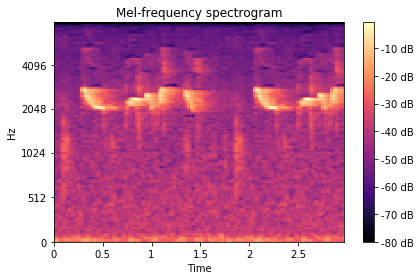

In [6]:
sample_path = "bird_songs_46/fold2/11-557.wav"

S = wav_to_db_spectro(sample_path)

splits = create_splits(S)

show_db_spectro(splits[0]);

In [7]:
samples, _ = librosa.load(sample_path)
Audio(samples[:sample_rate*3], rate=sample_rate)

---

In [8]:
def save_spectrogram_splits(fp, outdir):
    
    # Removing the directory path and the .wav extension
    fname = os.path.split(fp)[-1][:-4]

    audio = wav_to_db_spectro(fp)

    splits = create_splits(audio)

    for idx, split in enumerate(splits):

        outfp = os.path.join(outdir, f"{fname}_{idx:03d}.npy")

        np.save(outfp, split)

In [9]:
def do_once(func):
    
    action = input("Are you sure you want to run this? Y/N ")

    if action.lower() == 'y':

        return func

    else:

        print("Not running.")

In [10]:
def generate_all_spectrograms():
    
    for fp in glob.glob("bird_songs_46/fold*/*.wav"):
        
        save_spectrogram_splits(fp, "spectrograms/nanni/")

In [11]:
#! DATASET GENERATION - RUN ONLY ONCE

do_once(generate_all_spectrograms)()

Are you sure you want to run this? Y/N n
Not running.


TypeError: 'NoneType' object is not callable

---
## Loading the training data

Creating a shuffled training set as tensors.

With previous datasets, I ran some cleaning steps here, but with this dataset cleaning is not necessary.

In [12]:
global filepaths
filepaths = glob.glob(os.path.join("spectrograms/nanni/", "*.npy"))
np.random.shuffle(filepaths)

In [13]:
def to_mapped_tensor(arr):
    
    # Map from [80.0, 0.0] to [0.0, 1.0]
    mapped = (arr + 80.0) / 80.0
    
    tensor = tf.reshape(mapped, (len(mapped), 128, 128, 1))
    
    return tensor

In [14]:
def load_and_format_data(n=None, start=0, fpaths=filepaths):
    
    data = []
    
    if n:
        fps = fpaths[start : start + n]
    else:
        fps = fpaths

    for fp in fps:

        split = np.load(fp)

        data.append(split)
    
    arr = np.array(data)
    
    tensor = to_mapped_tensor(arr)
    
    return tensor

In [15]:
training_data = do_once(load_and_format_data)("spectrograms/nanni/", 5000)
training_data.shape

Are you sure you want to run this? Y/N n
Not running.


TypeError: 'NoneType' object is not callable

---
## Convolutional Autoencoder Training

In [16]:
def out(n, p, f, s):
    """
    A useful function for determining the output dimension of a layer.
    
    :param n: Input dimension (e.g. 64)
    :param p: Padding (1 if padding="same", 0 if padding="valid")
    :param f: Filter dimension (e.g. 3)
    :param s: Stride (e.g. 2)
    """
    
    return np.floor(((n + 2*p - f) / s) + 1)

In [17]:
out(128, 1, 3, 2)

64.0

In [18]:
class ConvNetAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvNetAutoEncoder, self).__init__()
        
        
        self.input_layer = tf.keras.layers.Input(shape=(128,128,1))                                       # 128x128x1
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same", strides=(2,2)) # 64x64x16
        self.maxp1 = tf.keras.layers.MaxPooling2D((2, 2), padding="same")                                 # 32x32x16
        self.conv2 = tf.keras.layers.Conv2D(8, (3, 3), activation="relu", padding="same")                 # 32x32x8
        
        self.encoded = tf.keras.layers.MaxPooling2D((2, 2), padding="same")                               # 16x16x8
        
        self.conv3 = tf.keras.layers.Conv2D(8, (3, 3), activation="relu", padding="same")                 # 16x16x8
        self.upsample1 = tf.keras.layers.UpSampling2D((2, 2))                                             # 32x32x8
        self.conv4 = tf.keras.layers.Conv2D(8, (3, 3), activation="relu", padding="same")                 # 32x32x8
        self.upsample2 = tf.keras.layers.UpSampling2D((2, 2))                                             # 64x64x8
        self.conv5 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same")                # 64x64x16
        self.upsample3 = tf.keras.layers.UpSampling2D((2, 2))                                             # 128x128x16
        self.conv6 = tf.keras.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")              # 128x128x1
        
    def encode(self, x):
        x = self.conv1(x)
        x = self.maxp1(x)
        x = self.conv2(x)
        x = self.encoded(x)
        return x
        
    def decode(self, x):
        x = self.conv3(x)
        x = self.upsample1(x)
        x = self.conv4(x)
        x = self.upsample2(x)
        x = self.conv5(x)
        x = self.upsample3(x)
        x = self.conv6(x)
        return x
    
    def call(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
def loss(x, x_bar):
    return tf.losses.mean_squared_error(x, x_bar)

def grad(model, inputs, targets):

    with tf.GradientTape() as tape:
        reconstruction = model(inputs)
        loss_value = loss(targets, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction

In [19]:
model = ConvNetAutoEncoder()
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [20]:
def train(model, training_data, epochs, batch_size,
          start=1, print_every=1,
          optimizer=tf.optimizers.Adam(learning_rate=0.001)):

    for epoch in range(start, start + epochs):

        losses = []

        for x in range(0, len(training_data), batch_size):
            
            x_input = training_data[x : x + batch_size]
            loss_value, grads, reconstruction = grad(model, x_input, x_input)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            losses.append(loss_value.numpy().mean())

        if epoch % print_every == 0:
            print("Epoch: \t\t", epoch)
            print(f"Average Loss: \t {np.mean(losses)}")

In [21]:
def save_weights(model, name):
    
    model.save_weights(name + ".h5")
    
    print("Saved weights.")

In [22]:
def run_training(epochs, batch_size, start=0, print_every=1, name=None):
    
    train(model, training_data, epochs, batch_size, start=start, print_every=print_every)
    
    if name is None:
        name = f"model{start + epochs}ep"
    
    save_weights(model, name)

In [23]:
do_once(run_training)(10, 20, 91, 2)

Are you sure you want to run this? Y/N n
Not running.


TypeError: 'NoneType' object is not callable

In [24]:
def instantiate_model(model, fname):
    
    model.build((1, 128, 128, 1))
    model.load_weights(fname)

do_once(instantiate_model)(model, "model90ep.h5")

Are you sure you want to run this? Y/N y


---
## Sanity Check

In [25]:
def tensor_to_array(tensor):
    
    return (tensor.numpy().reshape(128,-1) * 80.0) - 80.0

In [26]:
def show_tensor(S):
    
    return show_db_spectro(tensor_to_array(S))

In [27]:
def inverse_db_tensor(tensor):
    
    S_dB = tensor_to_array(tensor)
    
    S = librosa.db_to_power(S_dB)
    
    inv = librosa.feature.inverse.mel_to_audio(S)
    
    return inv

In [28]:
testing_data = load_and_format_data(3, start=10000)

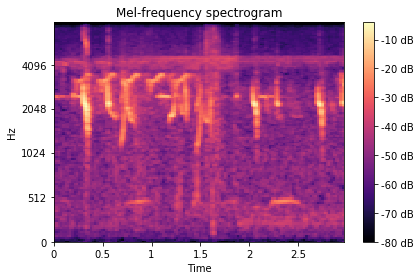

In [33]:
show_tensor(testing_data[0]);

In [34]:
recon = model(testing_data)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



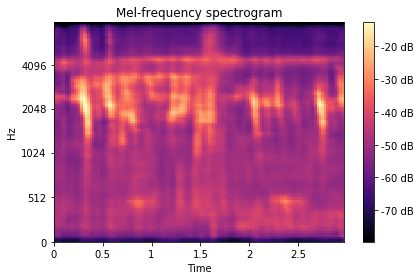

In [35]:
show_tensor(recon[0]);

---
## Post-processing

In [36]:
def sharpen(tensor, alpha=5):
    
    filter_blurred = ndimage.gaussian_filter(tensor, 1)
    
    sharpened = tensor + alpha*(tensor - filter_blurred)
    
    mapped = (sharpened - np.min(sharpened)) / (np.max(sharpened) - np.min(sharpened))
    
    return mapped

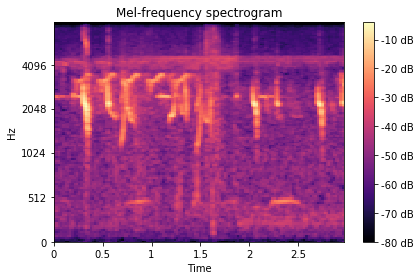

In [37]:
show_tensor(testing_data[0]);

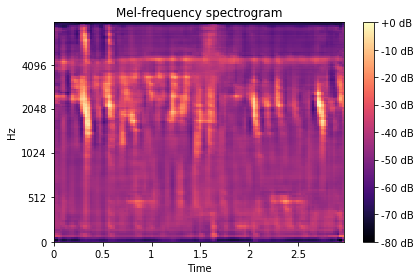

In [38]:
show_tensor(sharpen(recon[0]));

In [39]:
invt1 = inverse_db_tensor(testing_data[2])

In [40]:
Audio(invt1, rate=sample_rate)

In [41]:
invs1 = inverse_db_tensor(sharpen(recon[2]))

In [42]:
Audio(invs1, rate=sample_rate)

---
## Interpolation

Linearly interpolate between given encoded samples with a desired number of steps.

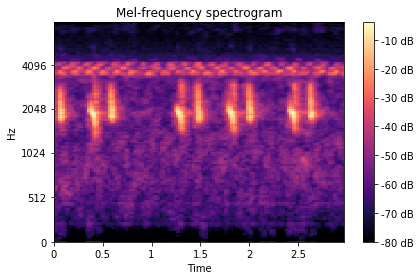

In [43]:
show_tensor(testing_data[2]);

In [44]:
invt2 = inverse_db_tensor(testing_data[2])

In [45]:
Audio(invt2, rate=sample_rate)

In [46]:
tenc = model.encode(testing_data)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [48]:
tenc[0].shape

TensorShape([16, 16, 8])

In [49]:
x = [0, 1]
y = [tenc[0], tenc[2]]

In [50]:
interp = scipy.interpolate.interp1d(x, y, axis=0)

In [51]:
steps = 5


step_size = 1 / (steps + 1)
frames = interp(np.arange(0, 1+step_size-0.001, step_size))

In [52]:
idec = model.decode(frames)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



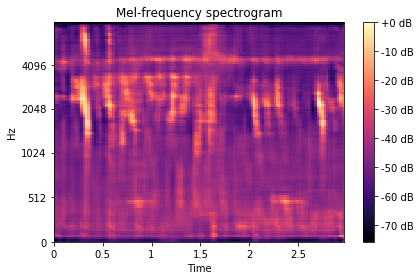

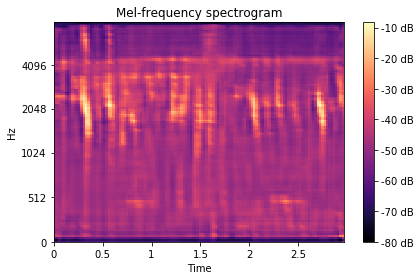

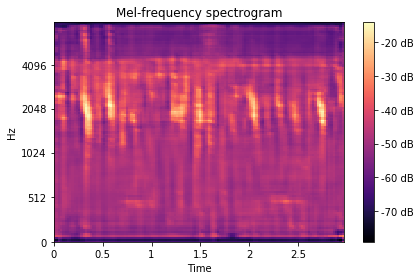

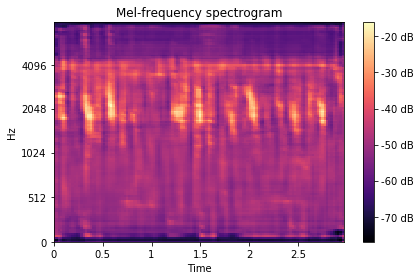

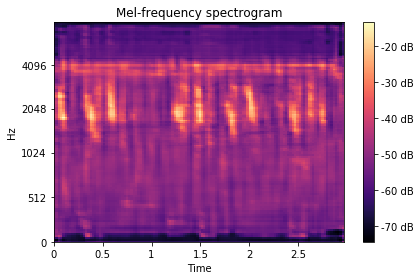

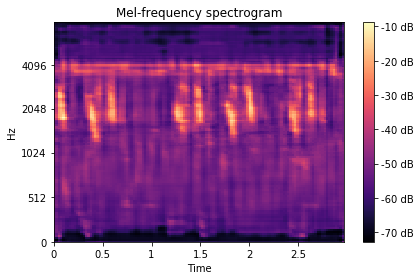

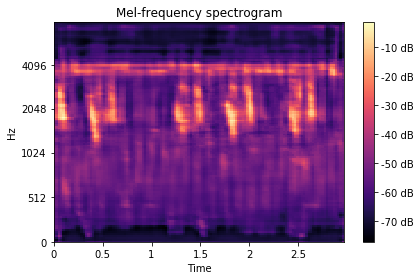

In [53]:
for frame in sharpen(idec):
    
    show_tensor(frame)

In [54]:
catted = tf.concat([_ for _ in idec], axis=1)
catted.shape

TensorShape([128, 896, 1])

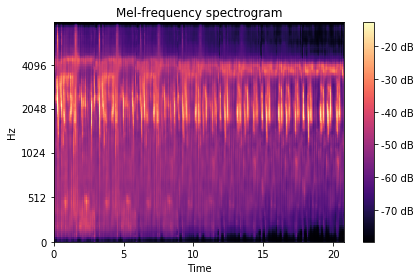

In [55]:
show_tensor(catted);

In [56]:
invcat = inverse_db_tensor(catted)

In [57]:
Audio(invcat, rate=sample_rate)

It worked!  Probably not the best samples to interpolate between, but it did it (ಥ _ ಥ)

---
## Now for the meaning

I chose 2 common bird songs, 2 threatened bird songs, and 3 now-extinct bird songs.

Common 1 - Mourning Dove

https://www.xeno-canto.org/sounds/uploaded/RFTXRYBVBX/XC451819-Mourning%20Dove%20-FL%2C%20River%20Lakes%2C%20March%2019%2C%202018%2C%201007%20AM.mp3

Common 2 - American Robin

https://www.xeno-canto.org/sounds/uploaded/KADPGEQPZI/XC364638-Robin%2003%20song%200544%20Mar%2028.mp3

Threatened 1 - Snowy Plover

https://www.xeno-canto.org/sounds/uploaded/RFTXRYBVBX/XC286696-Snowy%20Plover%20ground%20then%20flt%20-CA%2C%20end%20of%20Poe%20Rd%2C%20Salton%20Sea%2C%20April%2028%2C%202015%2C%201054%20AM.mp3

Threatened 2 - Spectacled Elder

https://download.ams.birds.cornell.edu/api/v1/asset/135488

Extinct 1 - Kauai O'o

https://download.ams.birds.cornell.edu/api/v1/asset/56465 

Extinct 2 - Huia

https://teara.govt.nz/files/high_source/s-13672-pc.mp3

In [58]:
# for fp in glob.glob("chosen/cropped/*.mp3"):
#    
#     audio = AudioSegment.from_mp3(fp)
#    
#     name = os.path.split(fp)[-1][:-4]
#    
#     audio.export("chosen/cropped/wav/"+name+".wav", format="wav")


# for fp in glob.glob("chosen/cropped/wav/*.wav"):
#    
#     save_spectrogram_splits(fp, "spectrograms/chosen/")

In [68]:
chosen = load_and_format_data(fpaths=glob.glob("spectrograms/chosen/*.npy"))

In [75]:
cset = tf.concat([chosen, tf.zeros_like(chosen[:1])], axis=0)

In [83]:
cset_encoded = model.encode(cset)

In [91]:
def interpolate(a, b, steps=3):
    
    x = [0, 1]
    y = [a, b]
    
    interp = scipy.interpolate.interp1d(x, y, axis=0)
    
    step_size = 1 / (steps + 1)
    frames = interp(np.arange(step_size, 1, step_size))
    
    return frames

In [92]:
a = interpolate(cset_encoded[0], cset_encoded[1])

In [95]:
a

array([[[[0.32188953, 0.        , 0.46184596, ..., 0.16478041,
          0.2856083 , 0.16804502],
         [0.28843177, 0.        , 0.3799151 , ..., 0.12714632,
          0.29797843, 0.19250944],
         [0.29522479, 0.        , 0.37377872, ..., 0.14864968,
          0.30037034, 0.19064992],
         ...,
         [0.29925886, 0.        , 0.38105072, ..., 0.12557474,
          0.28706057, 0.19002112],
         [0.28769306, 0.        , 0.3720337 , ..., 0.11326462,
          0.30198674, 0.18684176],
         [0.30012669, 0.        , 0.37070155, ..., 0.10257402,
          0.3017033 , 0.25064288]],

        [[0.28730125, 0.        , 0.43618155, ..., 0.20109298,
          0.38850257, 0.19154858],
         [0.27080445, 0.        , 0.35890491, ..., 0.17132182,
          0.38790251, 0.21009047],
         [0.28187234, 0.        , 0.35978496, ..., 0.14936593,
          0.37621296, 0.20616748],
         ...,
         [0.26832545, 0.        , 0.39035124, ..., 0.18238323,
          0.33629494, 0.2

In [102]:
frames = []

for i in range(len(cset_encoded) - 1):
    
    frames.append(cset_encoded[i])
    
    intermediate = interpolate(cset_encoded[i], cset_encoded[i+1])
    
    frames.extend(intermediate)
    
frames.append(cset_encoded[-1])

In [103]:
decoded = model.decode(frames)

In [104]:
sequence = tf.concat([sharpen(frame) for frame in decoded], axis=1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Parker\\Miniconda3\\envs\\proj2\\lib\\site-packages\\matplotlib\\pyplot.py'>

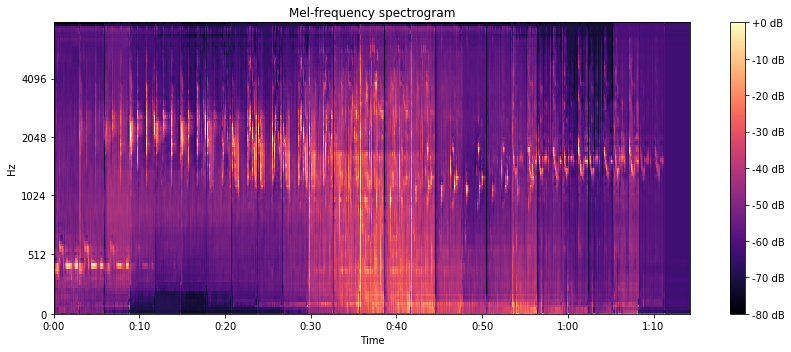

In [105]:
show_db_spectro(tensor_to_array(sequence), figsize=(12,5))

In [106]:
sequence_inv = inverse_db_tensor(sequence)

In [109]:
sequence_inv.shape

(1637888,)

In [110]:
a = sequence_inv[:]

In [130]:
ac = np.concatenate([a, np.random.normal(scale=0.0001, size=sample_rate*9)])

In [132]:
Audio(ac, rate=sample_rate)

In [133]:
librosa.output.write_wav("output.wav", ac, sr=sample_rate)

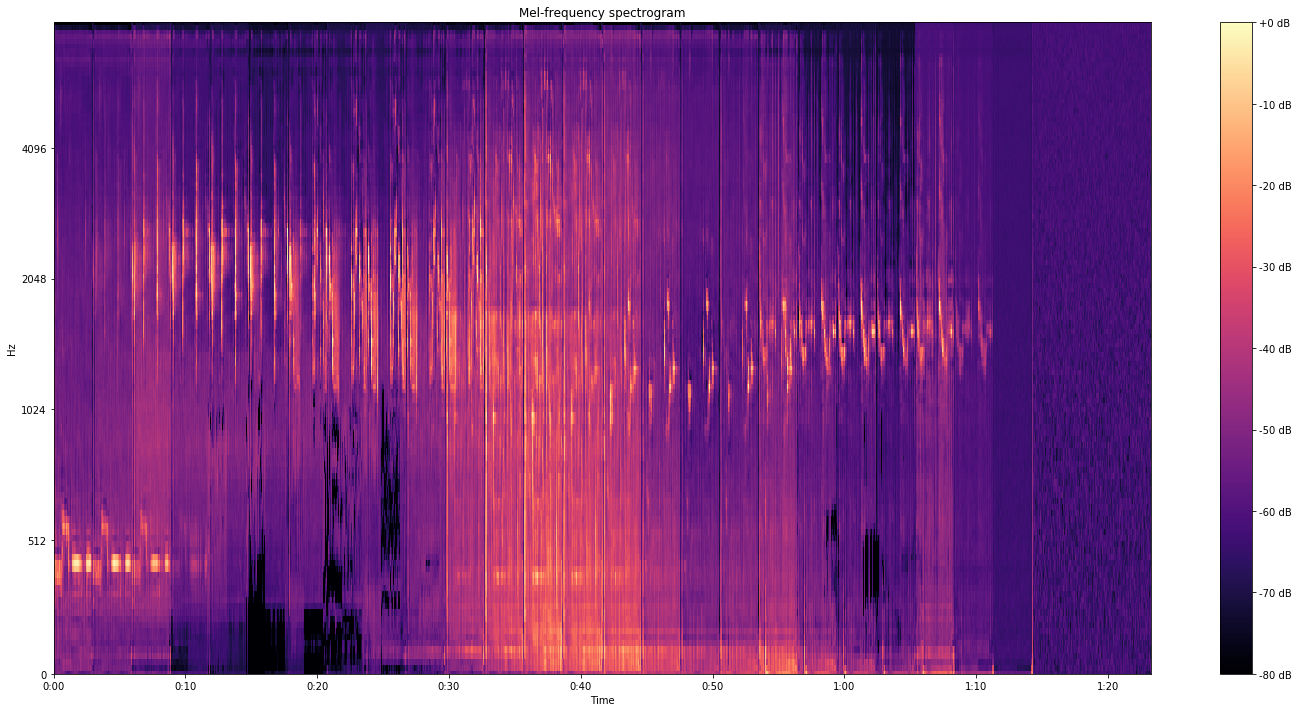

In [140]:
f = show_db_spectro(wav_to_db_spectro("output.wav"), figsize=(20, 10))

In [141]:
f.savefig("spectro.png")